In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from pprint import pprint

from warnings import filterwarnings
filterwarnings('ignore')

In [65]:
# Read dataset
data = pd.read_csv("../../Copper Dataset (version 2.0).csv")

# Split into features and target variables
X = data.iloc[:, :-2]
y = data['tensile_strength']

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=327)  # (1029 in train/ 258 in test)

### Build model with best parameters

Best hyperparameters found during hyperparamter tuning -

'n_estimators': 1400,\
'min_samples_split': 2,\
'min_samples_leaf': 1,\
'max_features': 'auto',\
'max_depth': 100,\
'bootstrap': True

In [66]:
# Create model skeleton
model = RandomForestRegressor(n_estimators=1600,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              max_features='auto',
                              max_depth=100,
                              bootstrap=True,
                              random_state = 627)

# Fit the model to the Training Data
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1600, n_jobs=None, oob_score=False,
                      random_state=627, verbose=0, warm_start=False)

R-2 score = 0.9566944515007013
Mean Squared Error = 57.368745837533694
Mean Absolute Error = 4.559936192915208


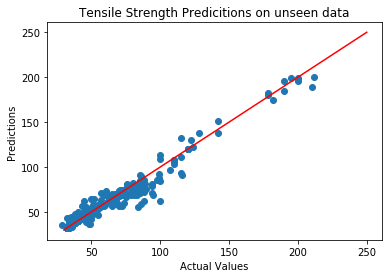

In [67]:
# Make predictions on Test Data
y_pred = model.predict(X_test)

# Evaluate model performance
print("R-2 score =", metrics.r2_score(y_test, y_pred))
print("Mean Squared Error =", metrics.mean_squared_error(y_test, y_pred))
print("Mean Absolute Error =", metrics.mean_absolute_error(y_test, y_pred))

model_accuracy = metrics.r2_score(y_test, y_pred)

# Visualise prediction accuracy
fig, ax = plt.subplots()

ax.scatter(y_test, y_pred)
ax.set_title("Tensile Strength Predicitions on unseen data")
ax.set_ylabel("Predictions")
ax.set_xlabel("Actual Values")
ax.plot([30, 250], [30,250], color='red')

plt.show()

In [68]:
# distinct_elements = {}
# count = []
# for col in data:
    
#     unique = np.unique(data[col]) # List of unique elements in a column of the dataframe
    
#     count.append(len(unique))
    
#     distinct_elements[col] = unique
    
# distinct_elements

In [69]:
def composition_from_tconductivity(desired_tc, data, model, n=10):
    
    # Use model to make predictions for synthetic data : "data"
    tc_predictions = model.predict(data)
    
    # Calculate absolute difference between the desireable Thermal Conducticity 
    # and the predictions on synthetic data
    difference = abs(tc_predictions - desired_tc)
    
    # Sort the indices of the absolute difference in ascending order, 
    # and store the indices of the first n predictions   
    indices = np.argsort(difference)[:n]
    
    # The composition of the materials with thermal conductivity closest to the desired value
    desired_compositions = data.iloc[indices, -28:].reset_index(drop=True)
    
    # Remove unnecessary dummy variables
    desired_compositions = desired_compositions.loc[:, (desired_compositions != 0).any(axis=0)]
    
    return desired_compositions

composition_from_tconductivity(150, X, model)

,cu,pb,fe,co,al,be,si,ti
0,97.300,0.4,0.0,0.2,0.2,1.900,0.2,0.00
1,97.300,0.0,0.0,0.2,0.2,1.900,0.2,0.00
2,97.300,0.4,0.0,0.2,0.2,1.900,0.2,0.00
3,97.300,0.0,0.0,0.2,0.2,1.900,0.2,0.00
4,96.550,0.0,0.2,0.0,0.0,0.000,0.0,3.25
5,96.550,0.0,0.2,0.0,0.0,0.000,0.0,3.25
6,97.300,0.0,0.0,0.2,0.2,1.900,0.2,0.00
7,97.675,0.0,0.0,0.2,0.2,1.725,0.2,0.00
8,97.675,0.0,0.0,0.2,0.2,1.725,0.2,0.00
9,97.675,0.0,0.0,0.2,0.2,1.725,0.2,0.00


In [118]:
def composition_from_tstrength(desired_value, synth_data, model, model_accuracy, n=10):
    
    # Use model to make predictions for synthetic data : "synth_data"
    ts_predictions = model.predict(synth_data)
    
    # Calculate absolute difference between the desireable Thermal Conducticity 
    # and the predictions on synthetic data
    difference = abs(ts_predictions - desired_value)
    
    # Sort the indices of the absolute difference in ascending order, 
    # and store the indices of the first n predictions   
    indices = np.argsort(difference)[:n]
    
    # The composition of the materials with thermal conductivity closest to the desired value
    desired_compositions = synth_data.iloc[indices, :]
    
    # Calculate the confidence of our results
    confidence_percentages = confidence_percentage(desired_compositions, model_accuracy)
    desired_compositions['Confidence %'] = confidence_percentages # Store results in with desired compositions
    
    # Remove unnecessary dummy variables
    desired_compositions = desired_compositions.loc[:, (desired_compositions != 0).any(axis=0)]
    
    # Sort alloys by confidence % (highest first)
    desired_compositions = desired_compositions.sort_values(by='Confidence %', ascending=False, )
    
    return desired_compositions.reset_index(drop=True)

composition_from_tstrength(169, X, model, model_accuracy)

,products,rod,wire,TF00,TH01,TH02,TM06,TM08,cu,pb,co,al,be,si,Confidence %
0,0,0,1,1,0,0,0,0,97.300,0.4,0.2,0.2,1.900,0.2,95.6
1,1,0,0,0,0,1,0,0,97.675,0.0,0.2,0.2,1.725,0.2,93.0
2,0,1,0,1,0,0,0,0,97.300,0.0,0.2,0.2,1.900,0.2,92.6
3,0,1,0,1,0,0,0,0,97.300,0.4,0.2,0.2,1.900,0.2,92.6
4,1,0,0,1,0,0,0,0,97.300,0.0,0.2,0.2,1.900,0.2,91.0
5,1,0,0,0,0,0,0,1,97.300,0.0,0.2,0.2,1.900,0.2,87.2
6,1,0,0,0,0,0,1,0,97.300,0.0,0.2,0.2,1.900,0.2,87.0
7,1,0,0,0,1,0,0,0,97.675,0.0,0.2,0.2,1.725,0.2,86.4
8,1,0,0,1,0,0,0,0,97.675,0.0,0.2,0.2,1.725,0.2,85.9
9,1,0,0,0,0,0,1,0,97.675,0.0,0.2,0.2,1.725,0.2,85.0


In [71]:
def confidence_percentage(desired_compositions, model_accuracy):
    
    predictions = model.predict(desired_compositions)
    
    error_perc = abs(predictions - desired_ts) / desired_ts * 100
    
    conf_perc = 100 - error_perc
    
    tot_conf_perc = conf_perc * model_accuracy
    
    tot_conf_perc = tot_conf_perc.round(1)
    
    return tot_conf_perc

In [ ]:
def get_unique_elements(data):

    unique_elements = []

    for col in data:
    
        unique = np.unique(data[col]) # List of unique elements in a column of the dataframe
        
        unique_elements.append(unique)
        
    return unique_elements

def get_best_samples(data, desired_value, n, method):
    
    # method = 1 ---> 'Tensile Strength'
    # method = 2 ---> 'Thermal Conductivity'
    method = 'tensile_strength' if method == 1 else 'thermal_conductivity'
    
    # Calculate absolute difference between actual and desired values
    abs_diff = abs(data[method] - desired_value)
    
    # Store index values of 'n' samples with values closest to the desired value
    best_sample_ids = np.argsort(abs_diff)[:n]
    
    # Return the best samples from the data using the index values
    best_samples = data.iloc[best_sample_ids]
    
    return best_samples

def all_possible_combinations(unique_elements):
    
    import itertools
    
    # Create a list of all unique value lists in unique_elements
    a = [ele for ele in unique_elements]
    
    # Generate a list of all possible permutations of the list elements in a
    permutations_list = list(itertools.product(*a))
    
    return permutations_list

In [114]:
def generate_synthetic_datapoints(desired_value, data, method, n=10):
        
    import pandas
    
    # method = 1 ---> 'Tensile Strength'
    # method = 2 ---> 'Thermal Conductivity'
    best_samples = get_best_samples(data = data, desired_value = desired_value, n = n, method = method)
    
    best_samples = best_samples.iloc[:, :-2]   # 
    
    unique_elements = get_unique_elements(data = best_samples)
    
    permutations_list = all_possible_combinations(unique_elements = unique_elements)
    
    synthetic_data_df = pd.DataFrame(permutations_list, columns = best_samples.columns)
    
    return synthetic_data_df

synthetic_data = generate_synthetic_datapoints(160, data, method=1, n=10)
synthetic_data

,bar,flat products & rod,flat products & wire,"flat products, rod & bar",forgings,pipe,plate,products,rod,rod & bar,...,co,al,be,cr,si,ti,ca,li,b,c
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000,0.0,0.0,3.25,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000,0.0,0.2,0.00,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.000,0.0,0.2,3.25,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,1.725,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294907,0,0,0,0,0,0,0,1,1,0,...,0.2,0.2,1.725,0.0,0.2,3.25,0.0,0.0,0.0,0.0
294908,0,0,0,0,0,0,0,1,1,0,...,0.2,0.2,1.900,0.0,0.0,0.00,0.0,0.0,0.0,0.0
294909,0,0,0,0,0,0,0,1,1,0,...,0.2,0.2,1.900,0.0,0.0,3.25,0.0,0.0,0.0,0.0
294910,0,0,0,0,0,0,0,1,1,0,...,0.2,0.2,1.900,0.0,0.2,0.00,0.0,0.0,0.0,0.0


In [86]:
best = composition_from_tstrength(180, synthetic_data, model, model_accuracy)
best

,products,wire,TD04,TF00,TH01,TH04,TM06,TM08,cu,al,be,si,ti,Confidence %
0,0,1,1,0,0,1,0,0,97.30,0.2,1.900,0.0,3.25,95.7
1,0,1,1,0,0,1,0,0,97.30,0.2,1.900,0.2,3.25,95.7
2,1,1,0,0,1,0,1,1,96.55,0.0,1.900,0.2,3.25,95.7
3,1,1,0,0,1,0,1,1,96.55,0.0,1.900,0.0,3.25,95.7
4,0,1,0,1,1,0,1,0,97.30,0.0,1.725,0.0,0.00,95.7
5,1,1,1,0,1,1,1,1,97.30,0.2,1.900,0.2,3.25,95.7
6,1,1,1,0,1,1,1,1,97.30,0.2,1.900,0.0,3.25,95.7
7,0,1,0,0,1,0,1,1,96.55,0.0,1.725,0.0,3.25,95.7
8,0,1,0,0,1,0,1,1,96.55,0.0,1.725,0.2,3.25,95.7
9,0,1,1,1,0,1,1,0,97.30,0.2,1.900,0.0,0.00,95.7


## Save and Load model

In [105]:
%%time
# import pickle


# with open('rf_tensile_strength.pickle', 'wb') as f:

#     pickle.dump(model, f)

# in your prediction file                                                                                                                           

with open('rf_tensile_strength.pickle', 'rb') as f:

    model = pickle.load(f)

preds = model.predict(synthetic_data.iloc[:, :])

Wall time: 52.4 s


In [106]:
model_accuracy

0.9566944515007013

In [115]:
def select_appropriate_model(method):
    
    import pickle
    
    # Select appropriate model for the problem
    if method == 1:   
        model_filepath = 'rf_tensile_strength.pickle'  # Model to predict Tensile Strength

    elif method == 2:   
        model_filepath = 'rf_thermal_conductivity.pickle'  # Model to predict Thermal Conductivity

    # Load model corresponding to the METHOD
    with open(model_filepath, 'rb') as f:
        model = pickle.load(f)
        
    return model

In [1]:
# User Input
METHOD = 2   # method = 1 : Tensile Strength, method = 2 : Thermal Conductivity
VALUE = 200


# Program functionality

# Global Variables 
MODEL_ACCURACY = 0.9567    # Mean R-squared score with 10-Fold CV
DATA = pd.read_csv("../../Copper Dataset (version 2.0).csv")

# Load model corresponding to the METHOD
model = select_appropriate_model(method = METHOD)
    
# Generate Synthetic Data for given Tensile Strength
synth_data = generate_synthetic_datapoints(desired_value = VALUE, data = DATA, method = METHOD, n = 10)

# Obtain most suitable alloy compositions with confidence percentage
results = composition_from_tstrength(desired_value = VALUE, 
                                     synth_data = synth_data,
                                     model = model, 
                                     model_accuracy = MODEL_ACCURACY)

results

NameError: name 'pd' is not defined